In [31]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sb
from tabulate import tabulate

In [87]:
# Get S&P500 information and store tickers in a list
sp500 = pd.read_csv('constituents.csv')
tickers = sp500["Symbol"]
tickers = tickers.tolist()

# Get returns for S&P500
start = '2010-01-01'
end = '2021-01-01'
adj_close = yf.download(tickers, start=start, end=end)["Adj Close"]

[*********************100%***********************]  505 of 505 completed

12 Failed downloads:
- XLNX: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- KSU: No data found, symbol may be delisted
- INFO: No data found, symbol may be delisted
- DISCK: No data found, symbol may be delisted
- VIAC: No data found, symbol may be delisted
- WLTW: No data found, symbol may be delisted
- PBCT: No data found, symbol may be delisted
- OGN: Data doesn't exist for startDate = 1262275200, endDate = 1609430400
- DISCA: No data found, symbol may be delisted
- BLL: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [88]:
adj_close

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,20.217159,4.562869,37.984016,6.434925,NaN,21.571365,8.730000,19.443871,32.668831,36.779999,...,13.777058,NaN,42.154297,32.362114,NaN,19.735056,52.506119,28.350000,10.873586,NaN
2010-01-04,20.366817,4.496877,37.890186,6.535085,NaN,22.034739,8.740000,19.613131,33.117538,37.090000,...,13.686161,NaN,42.747749,32.509365,NaN,19.802776,53.314461,28.670000,11.297343,NaN
2010-01-05,20.145590,5.005957,37.664989,6.546383,NaN,21.877523,8.530000,19.454668,33.322205,37.700001,...,13.523849,NaN,42.914665,32.122879,NaN,19.735056,55.002174,28.620001,11.695673,NaN
2010-01-06,20.074011,4.798553,37.993393,6.442256,NaN,21.670668,8.400000,19.562708,33.676449,37.619999,...,13.549825,NaN,43.285583,32.334538,NaN,19.593966,54.984417,28.400000,12.712694,NaN
2010-01-07,20.047979,4.939965,37.984016,6.430346,NaN,21.323137,8.400000,19.724773,33.644958,36.889999,...,13.491387,NaN,43.149574,32.757790,NaN,19.588322,56.245766,27.690001,14.136514,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,116.099579,15.660000,155.694885,130.802322,95.803833,94.910088,303.410004,105.434929,251.852798,499.859985,...,61.980591,NaN,38.367451,51.139622,98.612831,104.759193,143.369034,376.890015,41.754410,159.012238
2020-12-28,116.614220,16.059999,153.873230,135.480576,95.980125,94.743690,312.910004,104.890007,254.182388,498.950012,...,62.642315,NaN,38.496574,51.623184,98.730873,106.941254,143.023209,382.589996,41.773678,160.664474
2020-12-29,116.020416,15.860000,151.828720,133.676651,97.139854,95.056900,320.929993,105.415466,252.303085,502.109985,...,62.738213,NaN,38.063091,50.577103,97.884911,106.619797,146.442947,378.040009,41.205257,161.386734


In [89]:
adj_close_arr = adj_close.to_numpy()

In [90]:
adj_close_arr.shape

(2770, 505)

### Essential Functions

In [6]:
def shiftArr(arr, n):
    out = np.full_like(arr, np.nan)
    out[:-n] = arr[n:]
    return out

def normalize(arr):
    return arr-np.nanmean(arr, axis=1).reshape(-1, 1)

def scale(arr, booksize=20e6):
    return arr/np.nansum(abs(arr), axis=1, dtype=float).reshape(-1,1) * booksize

In [7]:
import numba
@numba.njit

def group_neutralize(arr, group, min=2):
    for di in range(len(arr)):
        unique_groups = np.unique(group[di])
        unique_groups = unique_groups[~np.isnan(unique_groups)]
        for g in unique_groups:
            if len(arr[di][group[di]==g]) >= min:
                arr[di] -= np.ones(arr[di].shape) * np.nanmean(arr[di][group[di]==g]) * (group[di]==g)
            else:
                arr[di][group[di]==g] = 0
    return arr

In [234]:
def tsdelta(arr, lookback=10):
    out = arr.copy()
    for di in range(lookback):
        out[di] = np.nan
    for di in range(lookback, len(arr)):
        out[di] = arr[di] - arr[di-lookback]
    return out

def tszscore(arr, lookback=10):
    out = arr.copy()
    for di in range(lookback):
        out[di] = np.nan
    for di in range(lookback, len(arr)):
        out[di] = (out[di] - np.nanmean(arr[di-lookback:di], axis=0)) / np.nanstd(arr[di-lookback:di], axis=0)
    return out

def maWindow(returns, window=5):
    out = np.copy(returns)
    for di in range(window):
        out[di] = np.nan
    for idx, row in enumerate(out):
        if idx >= window-1:
            out[idx] = np.mean(returns[idx-window+1:idx+1], axis=0)
        else:
            continue
    return out

In [9]:
def sharpe(pnl):
    s = np.nanmean(pnl) / np.nanstd(pnl) * np.sqrt(252)
    return s

def mdd(portfolio):
    peak = portfolio[0]
    max_draw = 0
    for idx, value in enumerate(portfolio):
        if value >= peak:
            peak = value
            peakidx = idx
        else:
            dd = ((value - peak)/peak) * 100
            if dd < max_draw:
                mddpeak = [peak, peakidx]
                trough = [value, idx]
                max_draw = dd
    return max_draw, mddpeak, trough

def turnover(alpha, booksize=20e6):
    lastDay = 0
    days = 0
    totalTurnover = 0
    for idx, day in enumerate(alpha):
        if idx!=0:
            posChange = day-lastDay
            bought = abs(posChange[posChange > 0].sum())
            sold = abs(posChange[posChange < 0].sum())
            dayTurnover = min(bought, sold)/booksize
            totalTurnover += dayTurnover
            days += 1
        lastDay = day
    return (totalTurnover/days) * 100

def lsReturns(alpha, returns):
    long = alpha.copy()
    long[long < 0] = 0
    longiipnl = np.multiply(long, returns)
    longpnl = np.nansum(longiipnl, axis=1)
    
    short = alpha.copy()
    short[short > 0] = 0
    shortiipnl = np.multiply(short, returns)
    shortpnl = np.nansum(shortiipnl, axis=1)
    
    return longpnl, shortpnl

### Alpha 1: 5d Returns Reversion

In [226]:
returns = (shiftArr(adj_close_arr,1) - adj_close_arr)/adj_close_arr
a = -tsdelta(adj_close_arr, 5)/adj_close_arr
b = normalize(a)
c = scale(b)
alpha = c

/var/folders/3q/cdf3qrtj06d84q4x0l6xslsr0000gn/T/ipykernel_85385/956451732.py:7: RuntimeWarning: Mean of empty slice
  return arr-np.nanmean(arr, axis=1).reshape(-1, 1)


In [227]:
iipnl = np.multiply(alpha, returns)
pnl = np.nansum(iipnl, axis=1)

+----+----------+-----------+------------+----------+-------------+--------------+
|    |   sharpe |   returns |   turnover |      mdd |    longOnly |    shortOnly |
|----+----------+-----------+------------+----------+-------------+--------------|
|  0 | 0.750011 |   5.67787 |    31.3074 | -21.5262 | 2.82277e+07 | -1.57454e+07 |
+----+----------+-----------+------------+----------+-------------+--------------+


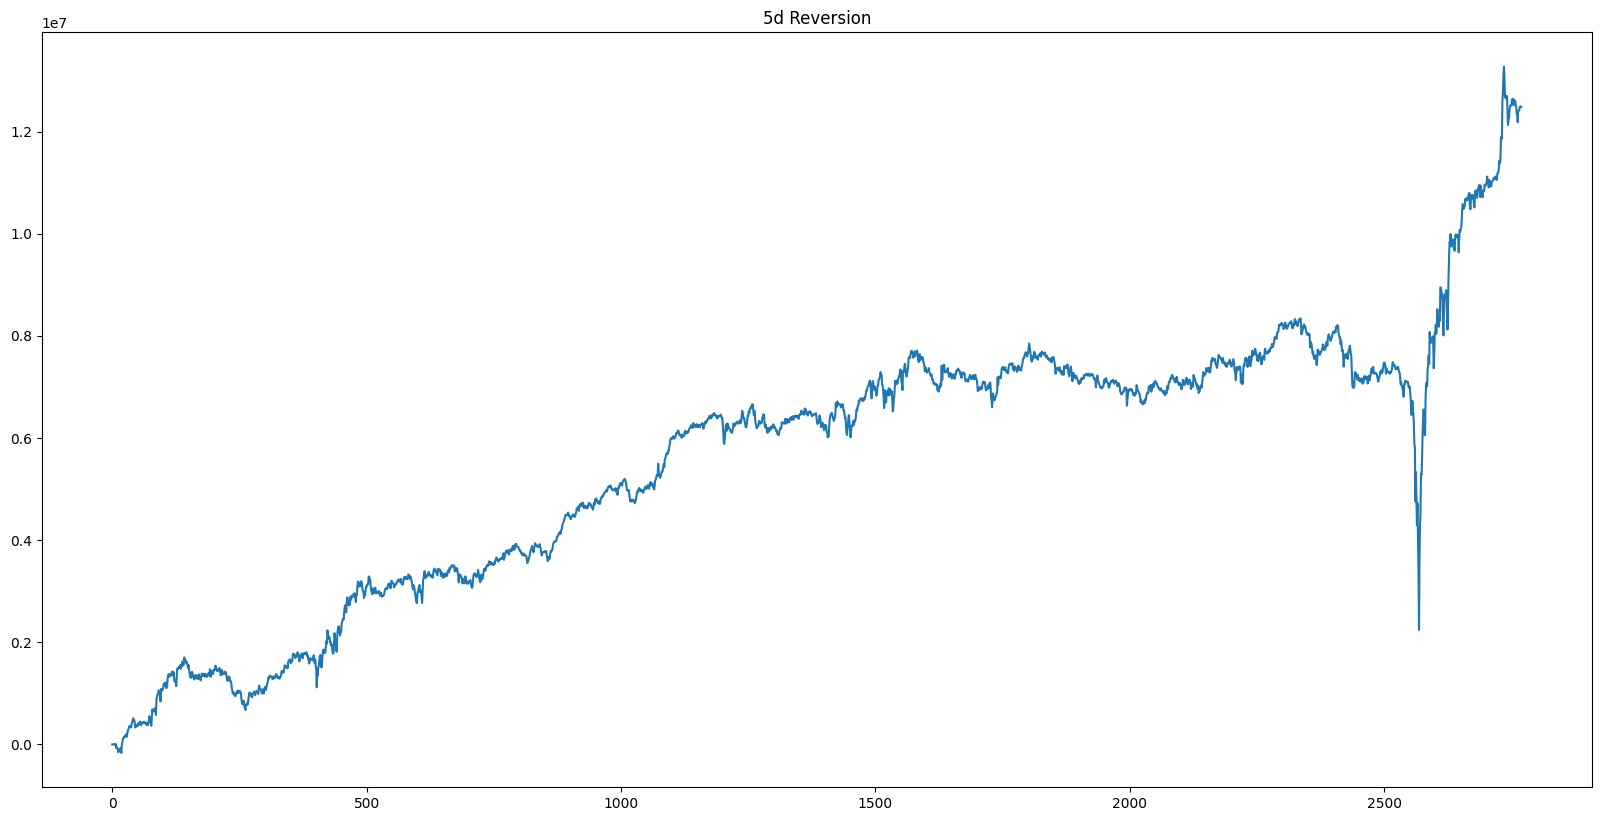

In [228]:
fig, ax = plt.subplots(1, figsize=(20,10), dpi=100)
ax.plot(pnl.cumsum())
ax.set_title('5d Reversion')

s = sharpe(pnl)
total_returns = np.nanmean(pnl)/20e6 * 252 * 100

cum_pnl = pnl.cumsum()
max_dd = mdd(cum_pnl+20e6)
tvr = turnover(alpha)
long, short = lsReturns(alpha, returns)

print(tabulate(pd.DataFrame.from_dict(dict(sharpe=[s], returns=[total_returns], turnover=[tvr], mdd=[max_dd[0]],
                                          longOnly=[long.sum()], shortOnly=[short.sum()])),
              headers='keys', tablefmt='psql'))

plt.show();

### Alpha 2: MA Reversion

In [255]:
returns = (shiftArr(adj_close_arr,1) - adj_close_arr)/adj_close_arr
a = maWindow(adj_close_arr, 20) - adj_close_arr
b = normalize(a)
c = scale(b)
alpha = c

/var/folders/3q/cdf3qrtj06d84q4x0l6xslsr0000gn/T/ipykernel_85385/956451732.py:7: RuntimeWarning: Mean of empty slice
  return arr-np.nanmean(arr, axis=1).reshape(-1, 1)


In [256]:
iipnl = np.multiply(alpha, returns)
pnl = np.nansum(iipnl, axis=1)

+----+----------+-----------+------------+----------+-------------+--------------+
|    |   sharpe |   returns |   turnover |      mdd |    longOnly |    shortOnly |
|----+----------+-----------+------------+----------+-------------+--------------|
|  0 |  1.23784 |   7.11803 |    18.7047 | -7.99975 | 2.92063e+07 | -1.35579e+07 |
+----+----------+-----------+------------+----------+-------------+--------------+


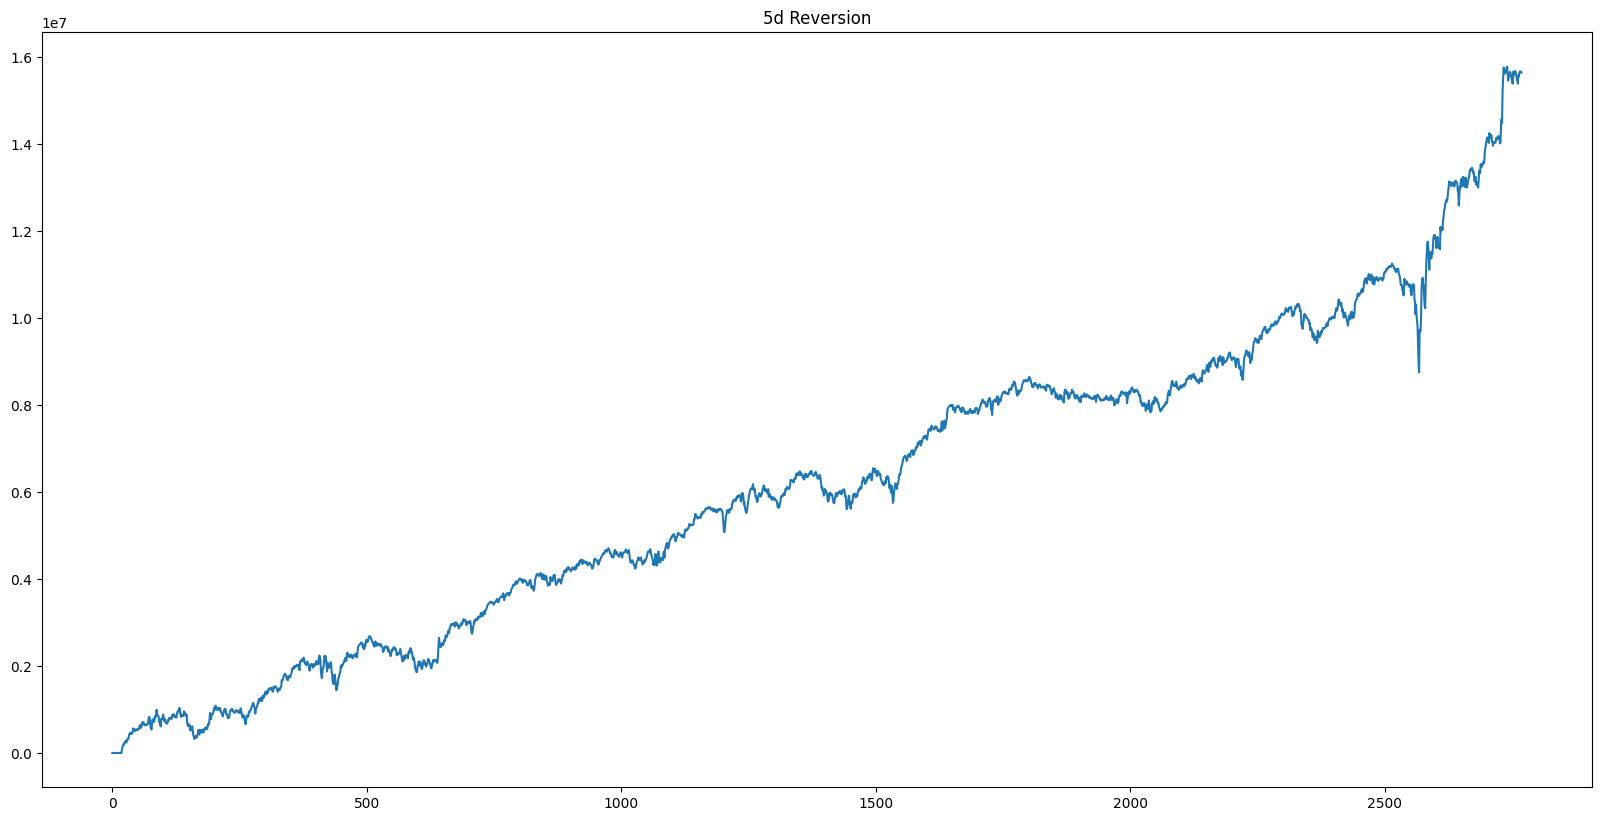

In [257]:
fig, ax = plt.subplots(1, figsize=(20,10), dpi=100)
ax.plot(pnl.cumsum())
ax.set_title('5d Reversion')

s = sharpe(pnl)
total_returns = np.nanmean(pnl)/20e6 * 252 * 100

cum_pnl = pnl.cumsum()
max_dd = mdd(cum_pnl+20e6)
tvr = turnover(alpha)
long, short = lsReturns(alpha, returns)

print(tabulate(pd.DataFrame.from_dict(dict(sharpe=[s], returns=[total_returns], turnover=[tvr], mdd=[max_dd[0]],
                                          longOnly=[long.sum()], shortOnly=[short.sum()])),
              headers='keys', tablefmt='psql'))

plt.show();